# A brief introduction to fitting intermediate angle $\ell=1$ modes

The purpose of this notebook is to show you how you would go about fitting $\ell=1$ modes using both maximum likelihood estimation (MLE) and Markov Chain Monte Carlo (MCMC).

We shall start with a few imports and defining the various functions needed throughout the rest of the notebook.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op

The functions included below have been arranged into classes to make them self-contained and easier to reuse in different circumstances. 

The common function to both MLE and MCMC is the likelihood function which supplies the probability (informally) of the data given the input parameters, i.e. essentially how well the model fits the data.

Our noise statistics are not Gaussian (unfortunately) but instead are $\chi^{2}_{2}$ and so our likelihood function is defined from Anderson (1990)

\begin{equation}
\ln \mathcal{L} = - \sum_{i}\left\lbrace\ln\left[M_{i}\left(\pmb{\theta}\right)\right] + \frac{P_{i}}{M_{i}\left(\pmb{\theta}\right)}\right\rbrace.
\end{equation}

$\mathcal{L}$ is our likelihood function, $M$ is our model for a given vector of parameters $\pmb{\theta}$, $P$ is the power and the sum is over each bin in the fitting region $i$.

This is defined in two different functions, one for each method, $\texttt{lnlike_mle}$ and $\texttt{lnlike_mcmc}$. The reason for this is the difference in sign of the log-likelihood function used in the optimisation. Whilst, as the name suggests MLE seeks to maximise the likelihood from an optimisation perspective it is easier to minimise a function. Therefore in $\texttt{lnlike_mle}$ we have multiplied the log-likelihood function by $-1$ so we are instead minimising the negative log-likelihood function. Whereas in MCMC the log-likelihood is fine in its current format.

Whilst this is adequate for MLE let us move onto the MCMC approach and start with Bayes' theorem

\begin{equation}
p(\pmb{\theta}|D, I) = \frac{p(\pmb{\theta}| I)p(D|\pmb{\theta}, I)}{p(D|I)},
\end{equation}

where $\pmb{\theta}$ is your vector or parameters, $I$ is any prior information and $D$ is your data.

We have already met $p(D|\pmb{\theta}, I)$ before, just not in this guise, as it is the likelihood function and so this is the same as function given above (except it is not in log!). $p(\pmb{\theta}| I)$ is the probability of the parameters given any prior information, so these are your priors. It is through this set of probabilities that you can add in any additional information you may know about the parameters, such as differing ranges etc. The marginal likelihood $p(D|I)$ gives us the  becomes a normalising constant when performing MCMC (due to the fact that we will work in log-space) but can be used in model comparison.

The final idea to cover before we move on is the model we'll be fitting to the data, this is in the form of a triple Lorentzian

\begin{equation}
M({\pmb{\theta}}) = \sum_{m=-\ell}^{\ell}\frac{\mathcal{E}_{\ell m}(i)S_{\ell}}{1 + \frac{4}{\Gamma^{2}}\left(\nu-\nu_{0}-m\nu_{\mathrm{s}} \right)^{2}} + W.
\end{equation}

The model is created by summing over a Lorentzian at frequency $\nu_{0}+m\nu_{\mathrm{s}}$ for each azimuthal components $m\in[-\ell, \ell]$ with a height given by $\mathcal{E}_{\ell m}(i)S_{\ell}$, of width $\Gamma$ and with a white noise component $W$. The rotational splitting of the mode is given by $\nu_{\mathrm{s}}$ and the angle of inclination of the mode enters through the visibility $\mathcal{E}_{\ell m}(i)$.

Explicitly the expression for $\mathcal{E}_{\ell m}(i)$ is given by (Gizon & Solanki 2003)

\begin{equation}
\mathcal{E}_{\ell m}(i) = \frac{(\ell-|m|)!}{(\ell+|m|)!}\left[ P_{\ell}^{|m|}\left(\cos i\right) \right]^{2} ,
\end{equation}

where $P_{\ell}^{|m|}\left(x\right)$ are Legendre polynomials. It is important to note that 

\begin{equation}
\sum_{m}\mathcal{E}_{\ell m}(i) = 1,
\end{equation}

and so this therefore $\mathcal{E}_{\ell m}(i)$ is the relative power contained within each component of the mode.

Since we know we only need the expression for $\ell=1, m=0$ and $\ell=1, m=\pm1$ it would be overkill to code this up completely and so let's expand the above equation for the relevant $\ell$ and $m$ values

\begin{equation}
\mathcal{E}_{\ell=1,m=0}(i) = \cos^{2}i,
\end{equation}
\begin{equation}
\mathcal{E}_{\ell=1,m=\pm1}(i) = \frac{1}{2}\sin^{2}i.
\end{equation}

Finally we can move onto the calculation of the mode height for which we will use the following equation

\begin{equation}
S = \frac{2A^{2}}{\pi\Gamma},
\end{equation}

where $A$ is the mode amplitude. The reason that we will fit for $A$ instead of the height is that $S$ and $\Gamma$ are highly correlated whereas fitting for $A$ reduces this correlation significantly.

In [2]:
class lnlike_mle(object):
    
    def __init__(self, _freq, _power, _model):
        self.freq = _freq
        self.power = _power
        self.model = _model
        
    def __call__(self, params):
        """
        Construct likelihood function for chi^2 2 d.o.f as given in Anderson (1990).

        Inputs: 
            :type freq: array-like
            :param freq: Array containing array of frequency values in fitting region

            :type power: array-like
            :param power: Array containing array of power values in fitting region.

            :type params: array-like
            :param params: Array containing model parameters

        Output:
            :type like: float
            :param like: Negative Log-likelihood value for data given input parameters
        """
        # Construct model for given set of parameters
        mod = self.model(params)

        # Input into equation (11) from Anderson (1990)
        # But we want negative log-likelihood (in MLE)
        # and so we negate the -1.0

        like = np.sum(np.log(mod) + self.power / mod)
        if not np.isfinite(like):
            return 1.0e30
        return like

class lnlike_mcmc(object):

    def __init__(self, _freq, _power, _model):
        self.freq = _freq
        self.power = _power
        self.model = _model

    def __call__(self, params):
        """
        Construct likelihood function for chi^2 2 d.o.f as given in Anderson (1990).

        Inputs: 
            :type freq: array-like
            :param freq: Array containing array of frequency values in fitting region

            :type power: array-like
            :param power: Array containing array of power values in fitting region.

            :type params: array-like
            :param params: Array containing model parameters

        Output:
            :type like: float
            :param like: Negative Log-likelihood value for data given input parameters
        """
        # Construct model for given set of parameters
        mod = self.model(params)

        # Input into equation (11) from Anderson (1990)
        # But we want log-likelihood not negative log-likelihood (in MCMC)
        # and so we add the -1.0
        like = np.sum(np.log(mod) + (self.power / mod))
        return -1.0*like
    
class lnprior(object):
    
    def __init__(self, _bounds):
        self.bounds = _bounds
        
    def __call__(self, params):
        # A fancy way of ensuring all parameters lie within the given bounds
        if not all(b[0] < v < b[1] for v, b in zip(params, self.bounds)):
            return -np.inf
        #lnprior = 0
        #lnprior += np.log(np.sin(np.radians(params[-2])))
        return 0.0

class lnprob(object):
    
    def __init__(self, _like, _prior):
        self.like = _like
        self.prior = _prior
        
    def __call__(self, params):
        lp = self.prior(params)
        if not np.isfinite(lp):
            return -np.inf
        return lp + self.like(params)
    
class Model(object):
    
    def __init__(self, _freq):
        self.freq = _freq
        
    def lorentzian(self, params):
        """
        Compute Lorentzian profile given input parameters
        Inputs: 
            :type freq: array-like
            :param freq: Array containing array of frequency values

            :type params: array-like
            :param params: Array containing model parameters

        Output:
            :type m: array-like
            :param m: Lorentzian profile created given input parameters
        """
        height, width, frequency = params

        return height / (1.0+ (4.0 / width**2)*(self.freq - frequency)**2)
    
    def __call__(self, params):
        """
        Sum of Lorentzian profiles providing a model for l=1 modes for a rms calibrated power spectrum

        Inputs: 
            :type freq: array-like
            :param freq: Array containing array of frequency values

            :type params: array-like
            :param params: Array containing model parameters

        Output:
            :type m: array-like
            :param m: model created given input parameters
        """
        # Parameters array is set out as follows
        amplitude, frequency, width, splitting, inclination, background = params

        # First calculate mode height
        height = 2.0 * amplitude **2 / (np.pi * width)

        # Now calculate mode visibilities (shortened versions taken from Handberg and Campante (2011))
        comp_m0 = np.cos(np.radians(inclination))**2
        comp_m1 = 0.5 * np.sin(np.radians(inclination))**2

        # Create array of mode heights for each component
        heights = height * np.array([comp_m0, comp_m1, comp_m1])
        comps = np.array([0, 1, -1])

        # Set up model array
        m = np.zeros(len(freq))
        for i in range(len(comps)):
            m += self.lorentzian([heights[i], width, frequency-(comps[i]*splitting)])
        return m + params[-1]
        
def generate_data(freq, params, model):
    """
    Generate artificial mode profile with chi^2 2 d.o.f. noise
    
    Inputs: 
        :type freq: array-like
        :param freq: Array containing array of frequency values
        
        :type params: array-like
        :param params: Array containing model parameters

    Output:
        :type data: array-like
        :param data: data created given input parameters
    """
    # Generate limit spectrum
    limit_spectrum = model(params)
    
    # Create data with noise from equation (A1) of Anderson (1990)
    data = -limit_spectrum * np.log(np.random.rand(len(freq)))
    return data, limit_spectrum
    

# Generating Artificial Data

Having gone through all the necessary functions let's start by generating some artificial data (the method is given in the appendix of Anderson 1990) with known parameters to demonstrate the fitting.

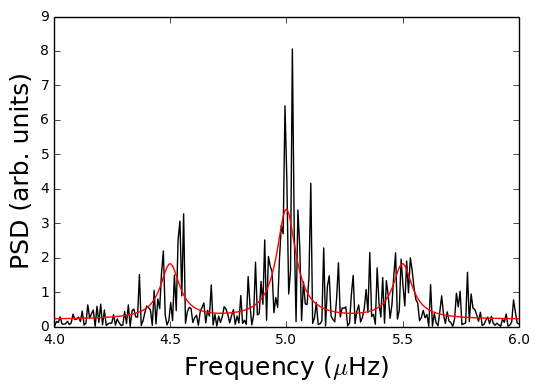

In [11]:
# Create frequency array
# bin width for 4-years of Kepler in uHz
bw = 1.0 / (4.0 * 365.0 * 86400.0) * 1e6
freq = np.arange(0, 10, bw)

# Create model instance
model_inst = Model(freq)

# Parameters for artificial data
# amplitude, frequency, width, splitting, inclination, background
params = [1.0, 5.0, 0.1, 0.5, 45.0, 0.2]

# Generate data
power, limit_model = generate_data(freq, params, model_inst)
plt.plot(freq, power, 'k')
plt.plot(freq, limit_model, 'r')
plt.xlim(4, 6)
plt.xlabel(r'Frequency ($\mu$Hz)', fontsize=18)
plt.ylabel(r'PSD (arb. units)', fontsize=18)

Now before we can get to the fitting we need to initialise the classes and create an array of bounds for the uniform priors used in the MCMC.

In [12]:
# Create prior, likelihood instances
bounds = [(0.0, 10.0), (0.0, 10.0), (0.0, 1.0), (0.0, 1.0), 
          (0.0, 90.0), (0.0, 1.0)]
Prior = lnprior(bounds)
#Lnlike = lnlike_mle(freq, power, model)
Lnlike = lnlike_mcmc(freq, power, model_inst)
Lnprob = lnprob(Lnlike, Prior)
Lnlike_mle = lnlike_mle(freq, power, model_inst)
Lnprob_mle = lnprob(Lnlike_mle, Prior)

## First Guesses

Both MLE and MCMC require intial guesses to start exploring the parameter space and it turns out that these are rather important (especially in the case of MLE).

Below are some methods that we'll go through as to how you could obtain some first guesses for a given $\ell=1$ mode.

To start with let's take one of the easiest parameters, the central frequency of the mode. Firstly we smooth the power spectrum with a gaussian filter of width $9$ $\mu$Hz$ in an attempt to remove the effects of noise and approximate the underlying mode profile. From this we then select the 3 highest peaks which, considering the intermediate angles being dealt with, should belong to each component of the mode. The central frequency of the mode can be approximated by the middle frequency value.

A handy by-product of the above method is that a first guess for the splitting can also be determined from the 3 highest peaks. The mean of the differences between the peak frequencies can be taken to be and approximation of the splitting value. 

In addition to the splitting the angle of inclination can also be determined from the 3 highest peaks, this time using the peak power values. As we saw in the previous section, the angle of inclination is determined by the ratio of the heights of the $m=\pm1$ components to the central $m=0$ component. Therefore we can calculate the mean ratio of the power values for the outer peak values compared to the central value and feed this back into the equation for $\mathcal{E}_{1, \pm1}$ in order to estimate $i$. It is worth noting that this is only a very rough way of approximating the angle, you could quite easily set the angle to 45 degrees as a rough guess.

The estimate of the width is simply set to $0.1$ $\mu$Hz which is appropriate for most red giants. This is simply because estimating the width from the power spectrum would take a little more thought.

Finally we'll move onto the estimates for the background and mode amplitudes. The background can be estimated by taking the mean of the first and last 100 bins, providing there is no contamination from other modes. Then to estimate the amplitude we take the power value from the central peak (from before) and approximate the amplitude by dividing by 2 and square rooting. This is by rearranging the equation for the mode height but negating the use of the width. As a result it will always give an overestimate because $\Gamma < 1$ $\mu$Hz for red giants.

(0, 10)

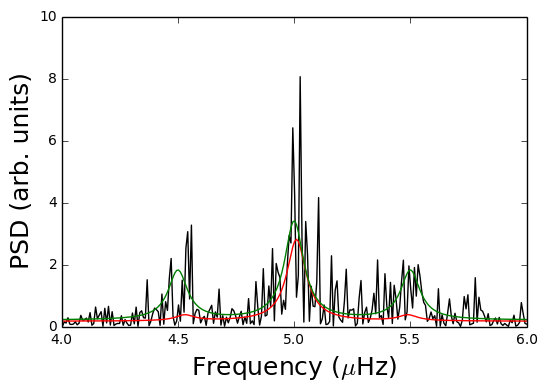

In [23]:
# Need to generate some first guesses
# Take central frequency as frequency of highest peak in region
# Smooth data first, less susceptible to noise
import scipy.ndimage
# smooth with Gaussian kernel convolution
power_smooth = scipy.ndimage.filters.gaussian_filter1d(power, 9.0)
#power_smooth = scipy.ndimage.filters.uniform_filter1d(power, 9)
# find all the peaks
peaks = np.array([i for i in range(1, len(freq)-1)
                 if power_smooth[i-1] < power_smooth[i] and
                 power_smooth[i+1] < power_smooth[i]])

# As intermediate star we can get away with taking 3 largest peaks
idx = np.argsort(power_smooth[peaks])[-3:]

# Save these frequencies for determining splitting
peak_freqs = np.sort(freq[peaks][idx])
# Determine splittings from differences
splitting_est = np.mean(np.diff(peak_freqs))
# Central frequency estimate from middle peak
central_freq_est = peak_freqs[1]
# Get inclination angle estimate from ratio of heights of 3 components
approx_heights = power[peaks][idx]
ratio = np.mean([approx_heights[0]/approx_heights[2], 
                 approx_heights[1]/approx_heights[2]])
angle_est = np.degrees(np.arcsin(0.5 * np.sqrt(ratio)))

# Background can be worked out as taking average of bins in extrema of
# fitting region
background_est = np.mean(np.r_[power[:100], power[-100:]])

# Compute amplitude estimate
m0_height = approx_heights[2]
amplitude_est = np.sqrt(m0_height/2.0) #(approx_heights[2]/2.0))

# Width
width_est = 0.1

# amplitude, frequency, width, splitting, inclination, background
# First guess parameters
p0 = [amplitude_est, central_freq_est, width_est, splitting_est,
      angle_est, background_est]


plt.plot(freq, power, 'k')
plt.plot(freq, model_inst(p0), 'r')
plt.plot(freq, model_inst(params), 'g')
#plt.plot(freq, power_smooth, 'r')
#plt.plot(freq[peaks][idx], power_smooth[peaks][idx], 'rD')
plt.xlabel(r'Frequency ($\mu$Hz)', fontsize=18)
plt.ylabel(r'PSD (arb. units)', fontsize=18)
plt.xlim(4, 6)
plt.ylim(0, 10)


As you can see this is not a bad first guess! It could certainly be improved with a little more thought, but this isn't really needed.

## An MLE approach

Let's now move onto how we go about performing MLE. To do this we make use of $\texttt{scipy.optimize}$ which has a variety of algorithms designed for minimising a given function (in our case the negative log-likelihood). 

The outputs of the minimisation are the parameter values and the inverse of the Hessian matrix, $H^{-1}$, (second derivative of the function to minimise with respect to each parameter). To get the uncertainties on each value we 
simply take the square root of the diagonal elements. This is because the inverse of the Hessian matrix is an approximation of the covariance matrix for which

\begin{equation}
C_{jj} = \sigma^{2}_{j},
\end{equation}

where $j$ represents a parameter of interest.

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:33: RuntimeWarning: invalid value encountered in log


[  1.00207696   5.0091889    0.12715695   0.48472395  40.75612288
   0.18902681]
[ 0.05270152  0.00970923  0.01956252  0.01348682  0.16569131  0.00587438]


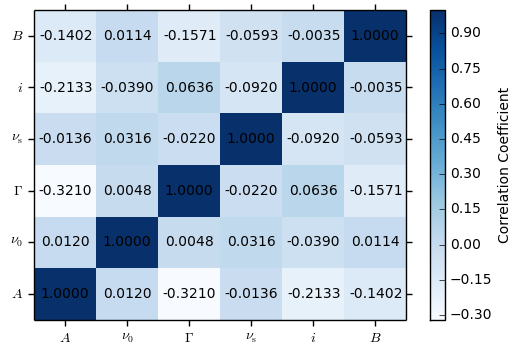

In [26]:
# Define some labels
labels = [r'$A$', r'$\nu_{0}$', r'$\Gamma$', r'$\nu_{\mathrm{s}}$', 
          r'$i$', r'$B$']

# Define likelihood function for use with MLE
Lnlike_MLE = lnlike_mle(freq, power, model_inst)

# Run optimisation
result = op.minimize(Lnlike_MLE, p0)
#print(result)
ndim = len(p0)

# Minimisation gives the inverse of the Hessian matrix as an output which is the covariance matrix
covariance = result["hess_inv"]

# Retrieve uncertainties
D = np.sqrt(np.diag(covariance))
print(result["x"])
print(D)

def cov2corr( A ):
    """
    covariance matrix to correlation matrix.
    """
    D = np.diag(np.sqrt(np.diag(A)))
    D_inv = np.linalg.inv(D)
    A = np.dot(D_inv, np.dot(A, D_inv))
    return A

# Create correlation map
R = cov2corr(covariance)

fig, ax = plt.subplots()
heatmap = ax.pcolor(R, cmap='Blues')
plt.colorbar(heatmap, label='Correlation Coefficient')
plt.yticks(np.arange(0.5, ndim+0.5), labels)
plt.xticks(np.arange(0.5, ndim+0.5), labels)
ax.get_xaxis().set_tick_params(direction='out', width=1)
ax.get_yaxis().set_tick_params(direction='out', width=1)
for y in range(R.shape[0]):
    for x in range(R.shape[1]):
        plt.text(x + 0.5, y + 0.5, '%.4f' % R[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )

The above plot is the correlation matrix and tell us the various correlations between the parameters in the fit. As you'd expect it is 1 across the diagonal, but a small investigation into the off-diagonal values can give some insight into the quality of the fit.

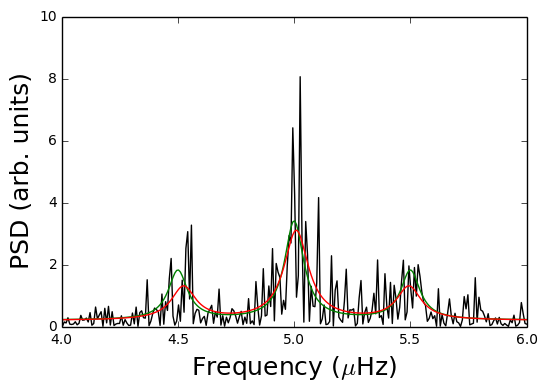

In [28]:
plt.figure(2)
plt.plot(freq, power, 'k')
plt.plot(freq, model_inst(params), 'g')
plt.plot(freq, model_inst(result["x"]), 'r')
plt.xlim(4, 6)
plt.ylim(0, 10)
plt.xlabel(r'Frequency ($\mu$Hz)', fontsize=18)
plt.ylabel(r'PSD (arb. units)', fontsize=18)

## The MCMC Approach

In [29]:
ndim, nwalkers = len(p0), 100
pos = [p0 + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
import emcee
sampler = emcee.EnsembleSampler(nwalkers, ndim, Lnprob)

In [30]:
# Clear and run the production chain.
print("Running MCMC...")
sampler.run_mcmc(pos, 1000, rstate0=np.random.get_state())
print("Done.")

Running MCMC...
Done.


(100, 1000, 6)


/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:564: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n = np.zeros(bins, ntype)
/usr/local/lib/python2.7/site-packages/numpy/lib/function_base.py:611: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  n += np.bincount(indices, weights=tmp_w, minlength=bins).astype(ntype)
/usr/local/lib/python2.7/site-packages/matplotlib/collections.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors_original != 'face':


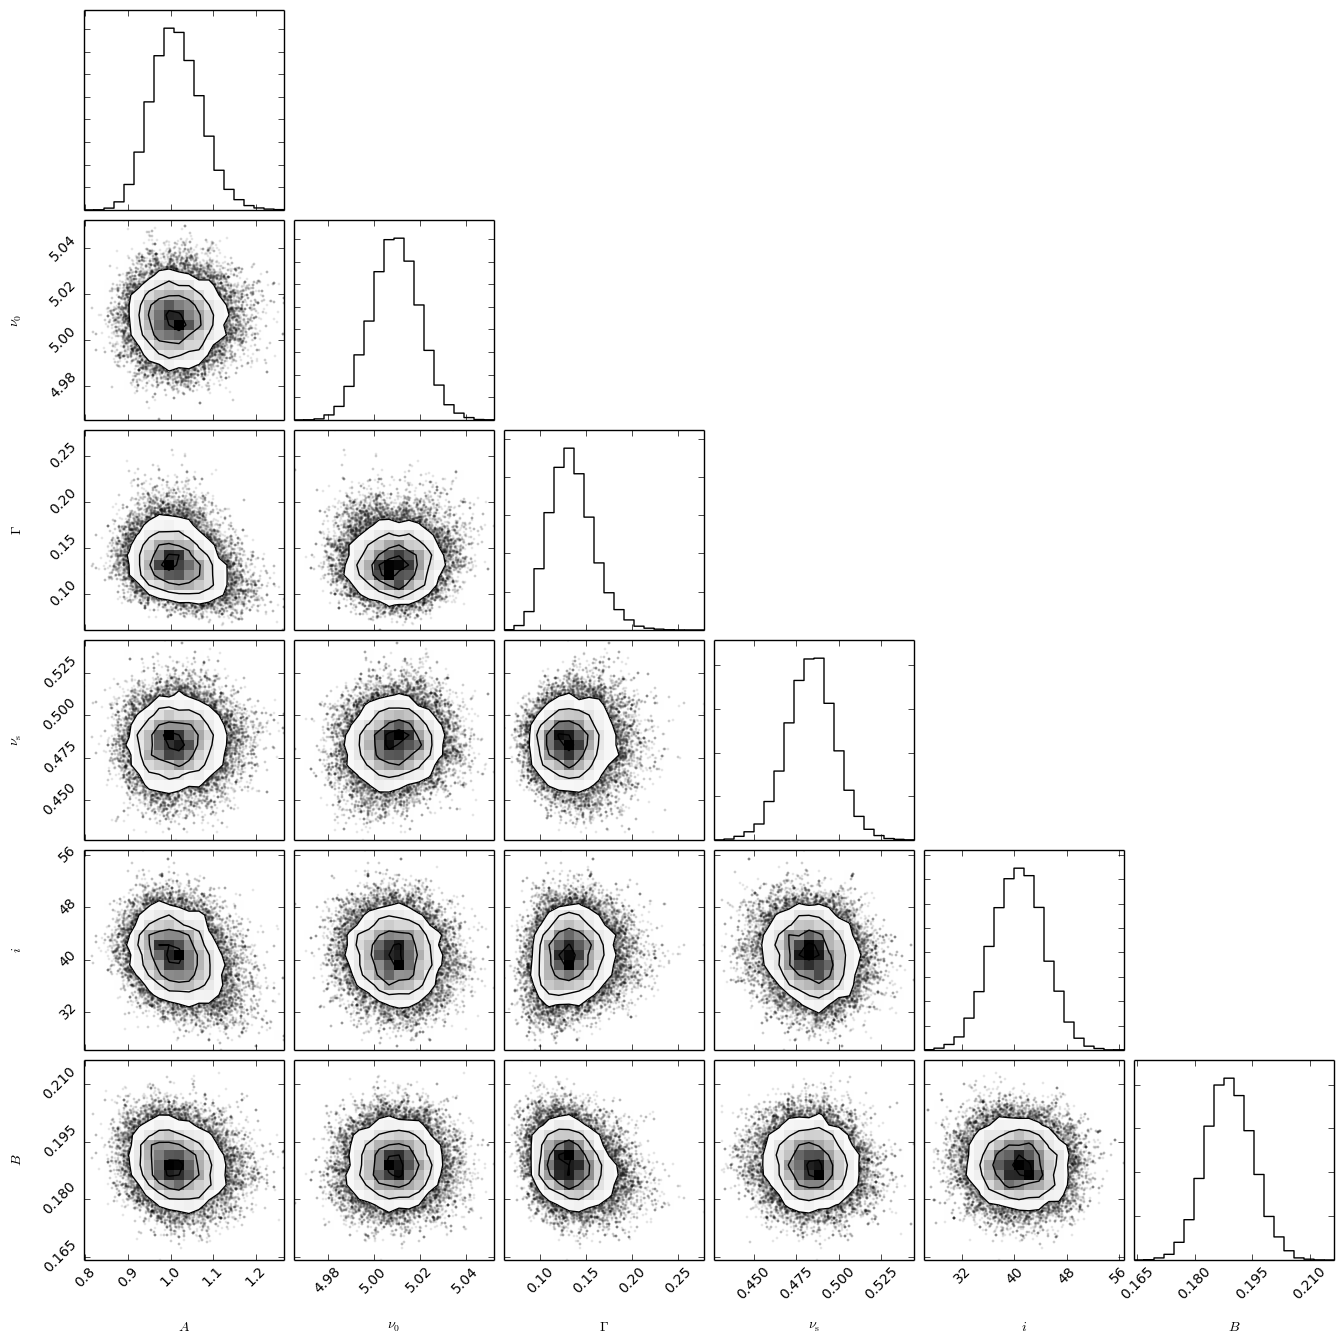

In [31]:
import corner
print(np.shape(sampler.chain))
samples = sampler.chain[:, 500:, :].reshape((-1, ndim))
corner.corner(samples, labels=labels)
plt.show()

We can also create a correlation map for the MCMC results. However the covariance matrix is not a natural output of the MCMC and so need to be created afterwards. Beware - for a large array ($>10000$) this can take minutes to compute! To negate this we take every $n$th sample, which was chosen to be 10 to keep the size of the chosen samples low ($\sim 5000$).

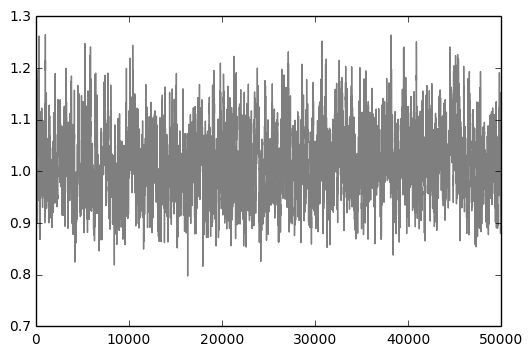

In [38]:
plt.plot(samples[:,0], alpha=0.5, color='k')

In [32]:
covariance_mcmc = np.cov(samples[::10, :].T)

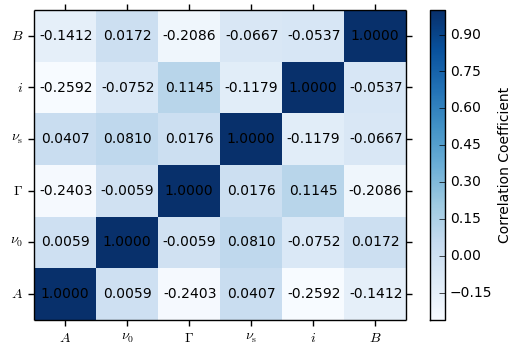

In [33]:
# Create correlation map
R_mcmc = cov2corr(covariance_mcmc)

fig, ax = plt.subplots()
heatmap = ax.pcolor(R_mcmc, cmap='Blues')
plt.colorbar(heatmap, label='Correlation Coefficient')
plt.yticks(np.arange(0.5, ndim+0.5), labels)
plt.xticks(np.arange(0.5, ndim+0.5), labels)
ax.get_xaxis().set_tick_params(direction='out', width=1)
ax.get_yaxis().set_tick_params(direction='out', width=1)
for y in range(R.shape[0]):
    for x in range(R.shape[1]):
        plt.text(x + 0.5, y + 0.5, '%.4f' % R_mcmc[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )

We can also look at the difference in correlations between parameters computed using the MLE and MCMC approach. However this is more for show than use and given that the MCMC should have been run for a little longer it is not the most valid of comparisons.

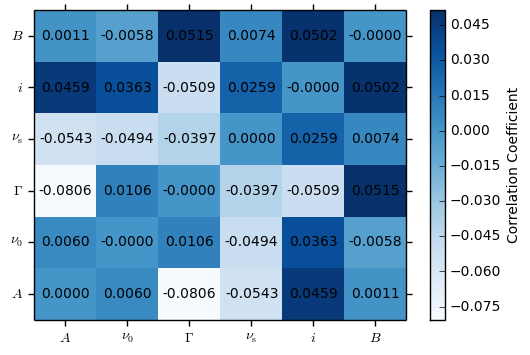

In [34]:
fig, ax = plt.subplots()
heatmap = ax.pcolor(R - R_mcmc, cmap='Blues')
plt.colorbar(heatmap, label='Correlation Coefficient')
plt.yticks(np.arange(0.5, ndim+0.5), labels)
plt.xticks(np.arange(0.5, ndim+0.5), labels)
ax.get_xaxis().set_tick_params(direction='out', width=1)
ax.get_yaxis().set_tick_params(direction='out', width=1)
for y in range(R.shape[0]):
    for x in range(R.shape[1]):
        plt.text(x + 0.5, y + 0.5, '%.4f' % (R-R_mcmc)[y, x],
                 horizontalalignment='center',
                 verticalalignment='center',
                 )

Let's extract the parameters and their uncertainties from the posterior samples. For our parameter value we shall take the median of the distribution and use calculate the 68.3% credible interval as our uncertainty (which may be asymmetric).

In [35]:
params = list(map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]), zip(*np.percentile(samples, [16, 50, 84], axis=0))))
#[1.0, 5.0, 0.1, 0.5, 45.0, 0.2]
print("MCMC results")
for i in range(len(params)):
    print("{0} : {1} + {2} - {3}".format(labels[i], *params[i]))


MCMC results
$A$ : 1.01137385329 + 0.0602094543846 - 0.0539905897364
$\nu_{0}$ : 5.00929482287 + 0.0104826228057 - 0.010605985771
$\Gamma$ : 0.132527933264 + 0.0246497667429 - 0.0215305094313
$\nu_{\mathrm{s}}$ : 0.483730003296 + 0.0137207899224 - 0.0138736024058
$i$ : 40.6089687346 + 3.88606924742 - 3.97040197749
$B$ : 0.188915721327 + 0.00626066278052 - 0.00583534664769


To examine the model let's plot a few random draws from the posterior samples.

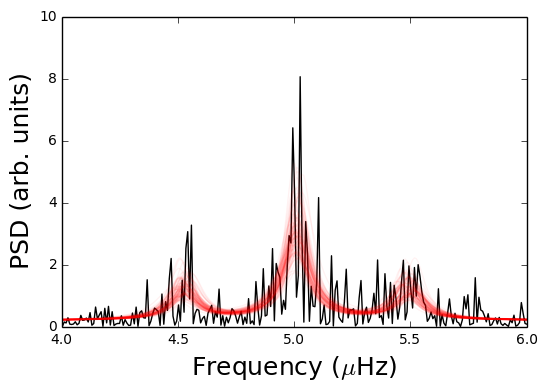

In [36]:
idx = np.random.randint(0, len(samples), 100)
# Plot random samples drawn from posteriors
plt.plot(freq, power, 'k')
for i in idx:
    plt.plot(freq, model_inst(samples[i,:]), 'r', alpha=0.05)
plt.xlim(4, 6)
plt.ylim(0, 10)
plt.xlabel(r'Frequency ($\mu$Hz)', fontsize=18)
plt.ylabel(r'PSD (arb. units)', fontsize=18)

## Improvements



Additional features can be added in, such as checking for convergence (which was not covered here). But we avoided that because in this case it should not be too much of a problem - for interest the Gelman-Rubin statistic is commonly used where a value of $\hat{R} \leq 1.001$ is commonly accepted.